### ReAct Agent Architecture
#### Aim
This is the intuition behind ReAct, a general agent architecture.
1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
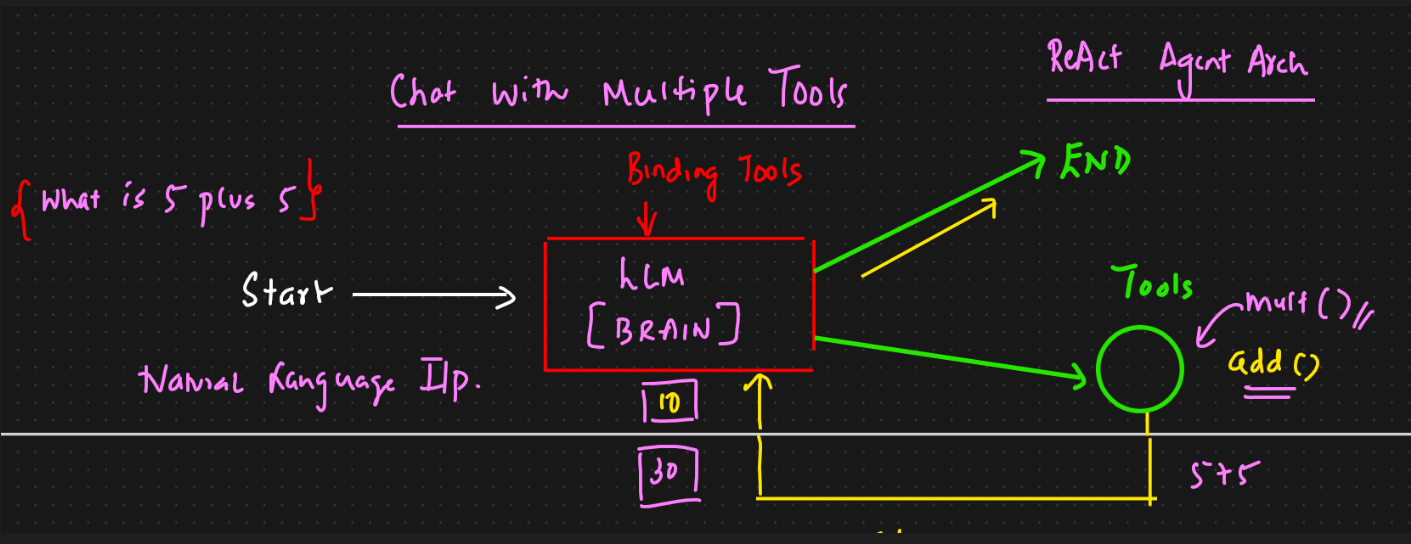

In [1]:
#load the env variables
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"

In [2]:
#define tools
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

arxiv_api = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api)

wiki_api = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=wiki_api)

tavily = TavilySearchResults()

#combine all these tools in the list
tools = [arxiv, wiki, tavily]

C:\Users\Suresh\AppData\Local\Temp\ipykernel_3728\3513204611.py:12: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [5]:
#test the working of tools

arxiv.invoke("1706.03762")

wiki.invoke("What is Machine Learning?")

tavily.invoke("provide latest AI news as of Jan 1st 2026")

[{'title': "From 'AI slop' to world models, bubbles and small models",
  'url': 'https://www.euronews.com/next/2026/01/01/from-ai-slop-to-world-models-bubbles-and-small-models-what-to-expect-from-ai-in-2026',
  'content': "War in Ukraine\n New Year\n Artificial intelligence\n Football\n Sport\n Germany\n\nLatest stories\n\nTech News AI world models and societal ‘clash’: The AI trends set to define 2026\n\nTop News Stories Today Latest news bulletin | January 1st, 2026 – Morning\n\nDestinations Swap overtouristed Dubai for nature-rich Oman in 2026\n\nIsrael Israel's Knesset votes down Beitar Illit annexation bill\n\nEurope\n\nCategories\n\n Europe News\n Europe Series\n France\n United Kingdom\n\nProgrammes [...] ## Which AI trends are coming in 2026? Euronews Next looks at the rise of world models and small language models as alternatives to traditional chatbots, with mounting concerns over AI safety, regulation, and the sustainability of the current AI boom.\n\nPeople getting peeved w

In [6]:
#create some custom tools
def add(a:int,b:int)->int:
    """
    adds two numbers
    """
    return a+b

def multiply(a:int,b:int)->int:
    """
    multiplies two numbers
    """
    return a*b

def divide(a:int,b:int)->float:
    """
    divides two numbers
    """
    return a/b

tools = [arxiv, wiki, tavily, add, multiply, divide]

In [9]:
#initialize the LLM Model
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools)

In [11]:
#test the LLM Model with tools
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content="Provide latest AI News as of 1st Jan 2026")]) #llm calling tavily tool

llm_with_tools.invoke([HumanMessage(content="What is Machine Learning?")]) #llm calling wiki tool

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jg6rg70mz', 'function': {'arguments': '{"query":"Machine Learning"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 709, 'total_tokens': 724, 'completion_time': 0.031143203, 'completion_tokens_details': None, 'prompt_time': 0.039996489, 'prompt_tokens_details': None, 'queue_time': 0.052137921, 'total_time': 0.071139692}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b78fa-e4fb-7f72-8c44-1059752dc638-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Machine Learning'}, 'id': 'jg6rg70mz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 709, 'output_tokens': 15, 'total_tokens': 724})

##### create a whole Graph Workflow with LangGraph

In [12]:
# 1.define StateSchema
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

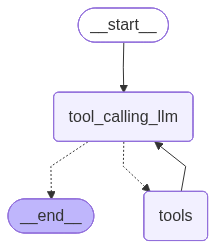

In [13]:
# 2.build the graph 
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
from langgraph.prebuilt import ToolNode,tools_condition

#Node definition
def tool_calling_llm(state:State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

#define the graph
graph = StateGraph(State)

#add nodes to the graph
graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

#create edges for these nodes
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools","tool_calling_llm") #this edge makes normal graph into ReAct Graph

#compile the graph
graph_builder = graph.compile()

#visualize the graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

##### Now after LLM calling the tool and getting the response from it , it again structures the response it got and send it as AI response

In [14]:
messages = graph_builder.invoke({"messages":[HumanMessage(content="Provide me the Latest AI News as of 2026 Jan 1st")]})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me the Latest AI News as of 2026 Jan 1st
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ddey6jmfk)
 Call ID: ddey6jmfk
  Args:
    query: latest AI news 2026 January 1st
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "New Privacy, Data Protection and AI Laws in 2026 - Pearl Cohen", "url": "https://www.pearlcohen.com/new-privacy-data-protection-and-ai-laws-in-2026/", "content": "Effective January 1, 2026, California is imposing comprehensive safety requirements on AI companion chatbots under Senate Bill 243. The law targets AI systems providing adaptive, human-like social interactions. Operators must clearly disclose when users could reasonably be misled into believing they are communicating with humans. For minor users, operators face heightened

In [15]:
msg = graph_builder.invoke({"messages":[HumanMessage(content="What is 2 plus 2 and then multiply by 3")]})

for msg in msg["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 2 plus 2 and then multiply by 3
================================== Ai Message ==================================
Tool Calls:
  add (4pqkht1es)
 Call ID: 4pqkht1es
  Args:
    a: 2
    b: 2
  multiply (pw2zyxj4e)
 Call ID: pw2zyxj4e
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: add

4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The final answer is 12.


##### Explanation : The Human Message goes to LLM (AI) , then LLM will choose the appropriate tool based on the Human Message query and it passes the query to that tool and that tool provide response back to LLM , and LLM will take that response and decides whether it need to call another tool to complete the query or make it structure and passes as output to the User - This is Called ReAct Architecture of Graph, Where Agent will perform 3 Actions i.e., ACT - OBSERVE - REASON to make the output better.

###### ====================================================================================================================================

### Problem :: Can We Chat With our Agent i.e., Will it remembers our previous conversation and can we ask based on previous results or queries???

##### Ans : For that we need to add Memory Functionality to our Agent, Without that Agent Can't use previous responses or queries to produce new results.

In [22]:
## for example 1:
msg = graph_builder.invoke({"messages":[HumanMessage(content="What is 4 plus 10")]})

for m in msg["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 4 plus 10
================================== Ai Message ==================================
Tool Calls:
  add (8hft7rk7b)
 Call ID: 8hft7rk7b
  Args:
    a: 4
    b: 10
================================= Tool Message =================================
Name: add

14
================================== Ai Message ==================================

The result of the function call is 14, which is the sum of 4 and 10.


In [29]:
msg = graph_builder.invoke({"messages":[HumanMessage(content="Divide that by 5")]})

for m in msg["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================
Tool Calls:
  divide (bykg0a8jn)
 Call ID: bykg0a8jn
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: divide

3.0
================================== Ai Message ==================================

The result of the division is 3.0.
